# ML models
---

This notebook contains Machine Learning Models exploration in order to create the best performing model.

**Data description:** 
- All the models we try below use the same data format. As there models accept tabular data, we have to feed these models with 2d data. Droughts is a slow phenomenon, and future droughts cannot be forecasted solely on a single day's weather observations. We need to include past weather observations. In this notebook, we concatenate weather observations over 180 days to create a gigantic features vector. To this vector we concatenate the soil data that is static. We could try to average data over multiple time windows (180, 90, 30, 5 days for instance), but this was tried in a separate file and did not give promising results.
- We make sure that when creating training data from the `timeseries` and `soil_data` datasets, two consecutive observations in the resulting X dataframe do not start on consecutive days. Two observations are separated by 180 days. In other words, we don't find the same data twice in the resulting X dataframe. This allows to avoid high correlation in our independent variables.

**Models description:**
- We compare all our ML models to two baseline models. The first model predicts all droughts to be identical to the prediction date. The second one is based on the past 2 drought scores and extrapolates future drought socres linearly.
- We then focus on simple models with various normatlization:
    - Ridge regression
    - No normalization
    - Robust normalization
    - Min-max normalization
    - Gradient Boosted trees

**Features selection and dimension reduction:**
- As these simple models are not able to beat our naive models, we decide to perform feature selection. We iteratively reduce the data's dimension, by averaging correlated variables, which allows to drastically reduce the data's dimension.
- We then decide to try reducing dimension using PCA and by keeping only the first Principal Components.

**Cross validation on parameters:**
- One way of reducing data dimension is to reduce the time window that we take into account. We do cross validation on this parameter to find the best one.
- Finally, we do cross validation to choose the best regularization parameter.

---

Finally, we try fitting a simple FFNN for fun to see how it would perform.

--- 

**Conclusion:** Even with all this model exploration and selection, we are not able to beat the most simple naive models. We thus try using a LSTM to solve the problem, that will be able to take into account data's temporality, which is tremendous for Time Series prediction.


In [1]:
import os
import pickle
import random
import re
import time
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

tqdm.pandas()

import torch
import torch.nn.functional as F
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from torch import nn
from torch.optim import Adam

import constants
import preprocessing
import process_outputs

# 1. Import and transform data

In [3]:
# Import data, transform it and delete it to make some space on the RAM
soil_data = preprocessing.load_clean_data("soil")
train_timeseries = preprocessing.load_clean_data("train")
print("Transforming train data...")
X_train, y_target_train = preprocessing.transform_data_2d(train_timeseries, soil_data)
print("Transformation done")
del train_timeseries

val_timeseries = preprocessing.load_clean_data("validation")
print("Transforming train data...")
X_valid, y_target_valid = preprocessing.transform_data_2d(val_timeseries, soil_data)
print("Transformation done")
del val_timeseries

del soil_data

Loading existing clean soil data
Loading existing clean train data
Transforming train data...


100%|██████████| 3059/3059 [10:08<00:00,  5.03it/s]


Transformation done
Loading existing clean validation data
Transforming train data...


100%|██████████| 3059/3059 [00:52<00:00, 58.49it/s]

Transformation done


We scale the data in two fashion, to compare results on these two scaled datasets.

In [4]:
# Run time: 30s
X_train_scaled, X_valid_scaled = preprocessing.custom_scaler(X_train, X_valid)

normalization_coefficients = X_train.max(axis = 0)
X_train_norm = X_train / normalization_coefficients
X_valid_norm = X_valid / normalization_coefficients

/home/pierre_counathe/venvDLgcp/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/pierre_counathe/venvDLgcp/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


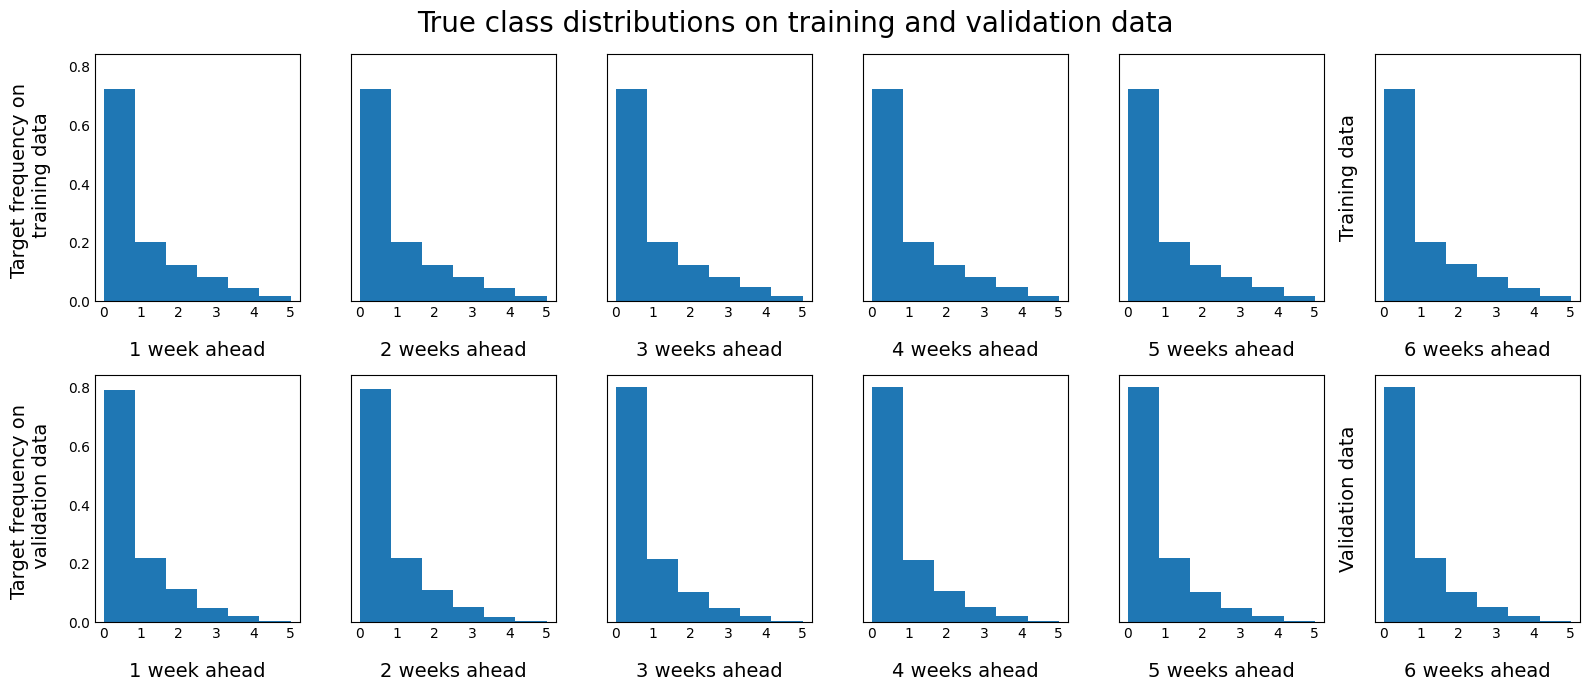

In [5]:
fig, axs = plt.subplots(2, 6, figsize = (16, 7), sharey = True)
axs[0][0].set_ylabel("Target frequency on \n training data", labelpad=12, fontsize=14)
axs[1][0].set_ylabel("Target frequency on \n validation data", labelpad=12, fontsize=14)
axs[0][5].set_ylabel("Training data", labelpad=12, fontsize=14)
axs[1][5].set_ylabel("Validation data", labelpad=12, fontsize=14)
fig.suptitle('True class distributions on training and validation data', 
             fontsize=20)
for i in range(6):
    week_i_train_labels = preprocessing.round_and_intify(list(np.split(y_target_train, 6, 1)[i].flat))
    axs[0][i].hist(week_i_train_labels, bins = 6, density = True)
    axs[0][i].set_xticklabels([0, 1, 2, 3, 4, 5])
    axs[0][i].set_xticks([0, 1, 2, 3, 4, 5])
    axs[0][i].tick_params(axis='both', which='both', length=0)
    if i == 0:
        weekname = 'week'
    else:
        weekname = 'weeks'
    axs[0][i].set_xlabel(f"{i+1} {weekname} ahead", labelpad=15, fontsize=14)
    
    week_i_pred_labels = preprocessing.round_and_intify(list(np.split(y_target_valid, 6, 1)[i].flat))
    axs[1][i].hist(week_i_pred_labels, bins = 6, density = True)
    axs[1][i].set_xticklabels([0, 1, 2, 3, 4, 5])
    axs[1][i].set_xticks([0, 1, 2, 3, 4, 5])
    axs[1][i].tick_params(axis='both', which='both', length=0)
    axs[1][i].set_xlabel(f"{i+1} {weekname} ahead", labelpad=15, fontsize=14)
    
fig.tight_layout()
plt.show()

# 2. Benchmark models

We define here naive models to have a benchmark to be able to compare the performances of our following models:
- A model that predicts that all following droughts will be the same as the prediction date's
- A model that extrapolated liearly droughts using previous two droughts scores in each `fips`

In [46]:
X_train_dumb, y_target_train_dumb = preprocessing.get_dumb_data("train")
X_valid_dumb, y_target_valid_dumb = preprocessing.get_dumb_data("validation")

In [82]:
def naive_predictor_one_observation(X, target_size = 6):
    """Uses the current day's drought score to predict the next drought scores, 
    assuming the drought level won't change in the upcoming weeks
    """
    y = np.repeat([X[:, 1]], target_size, axis=0).T
    return y

    
def naive_predictor_two_observations(X, target_size = 6):
    """Uses the current and previous days' drought scores to predict the next drought scores, 
    assuming the drought levels will vary in a linear way, similarly to what has happened last 2 days
    """
    y = np.repeat([X[:, 1]], target_size, axis=0).T
    one_day_evolution = X[:, 1] - X[:, 0]
    evolution_matrix = np.repeat([one_day_evolution], 6, axis=0).T
    y_delta = evolution_matrix * np.array([1, 2, 3, 4, 5, 6])
    return np.clip(y + y_delta, 0, 5)  # Limit output between 0 and 5

NAIVE MODEL, SINGLE OBSERVATION, PERFORMANCES
---------------------------------------------
PREDICTIONS ON THE TRAIN TIMESERIES, FOR INFORMATION PURPOSES


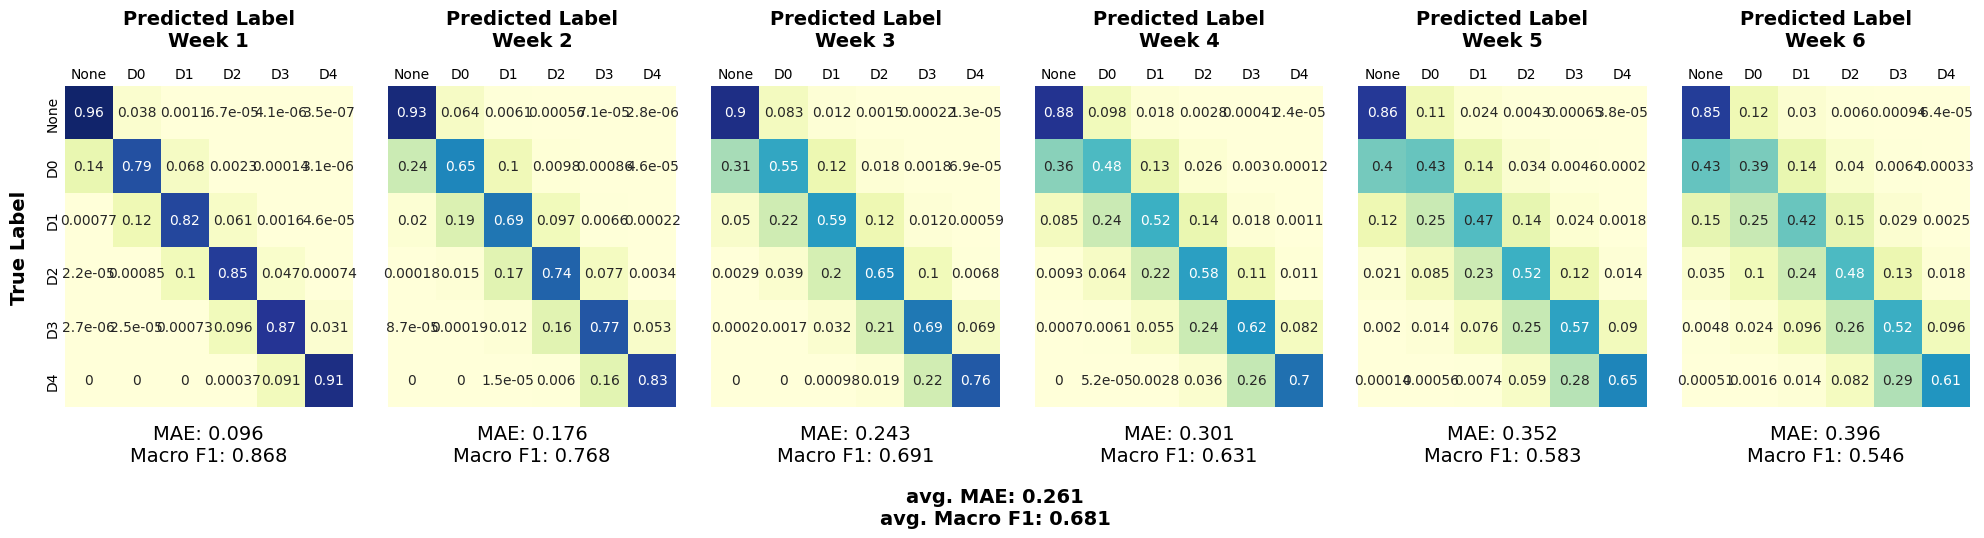

PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES


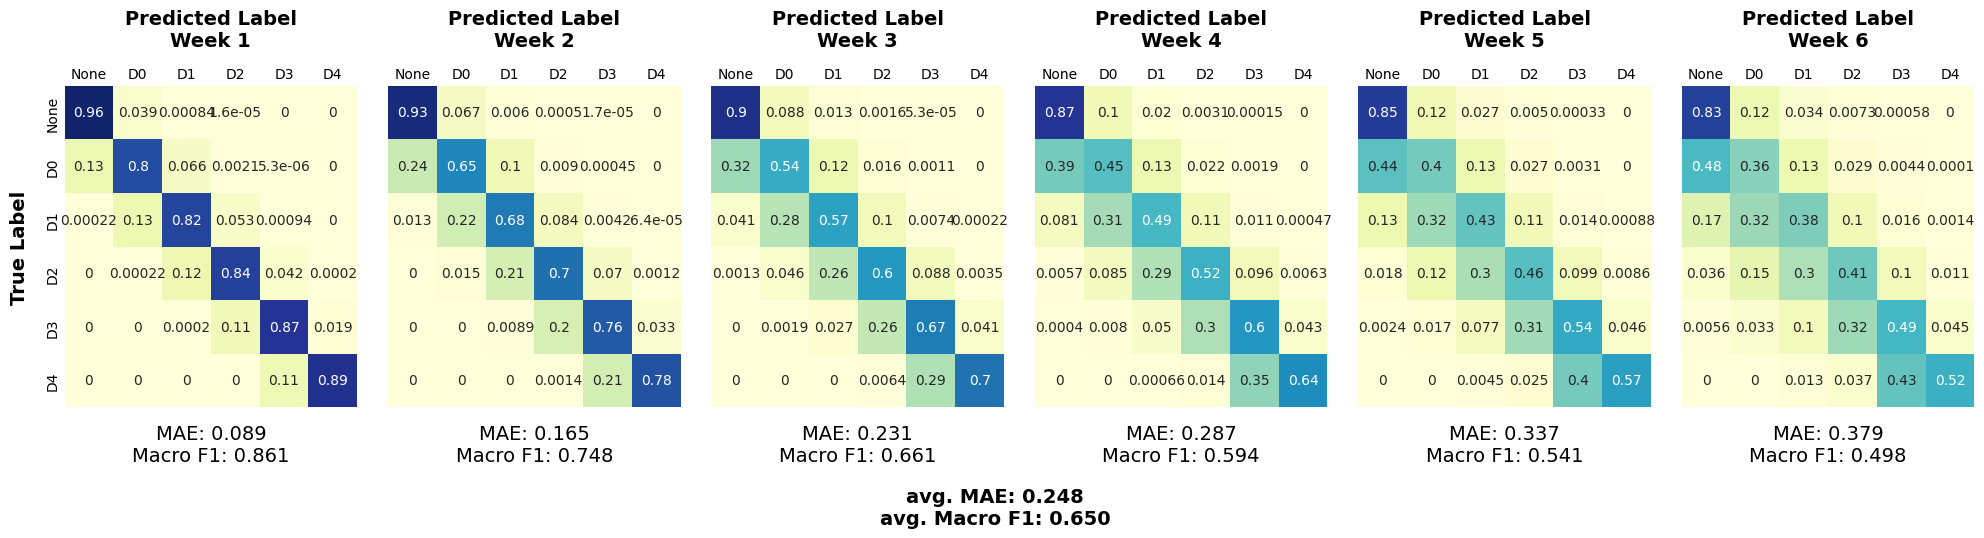

In [76]:
# about 1.5 min to run
print("NAIVE MODEL, SINGLE OBSERVATION, PERFORMANCES")
print("---------------------------------------------")
print("PREDICTIONS ON THE TRAIN TIMESERIES, FOR INFORMATION PURPOSES")
y_pred_train_dumb_1 = naive_predictor_one_observation(X_train_dumb)
process_outputs.summarize(y_target_train_dumb, y_pred_train_dumb_1)

print("PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES")
y_pred_valid_dumb_1 = naive_predictor_one_observation(X_valid_dumb)
process_outputs.summarize(y_target_valid_dumb, y_pred_valid_dumb_1)

NAIVE MODEL, TWO OBSERVATION, PERFORMANCES
------------------------------------------
PREDICTIONS ON THE TRAIN TIMESERIES, FOR INFORMATION PURPOSES


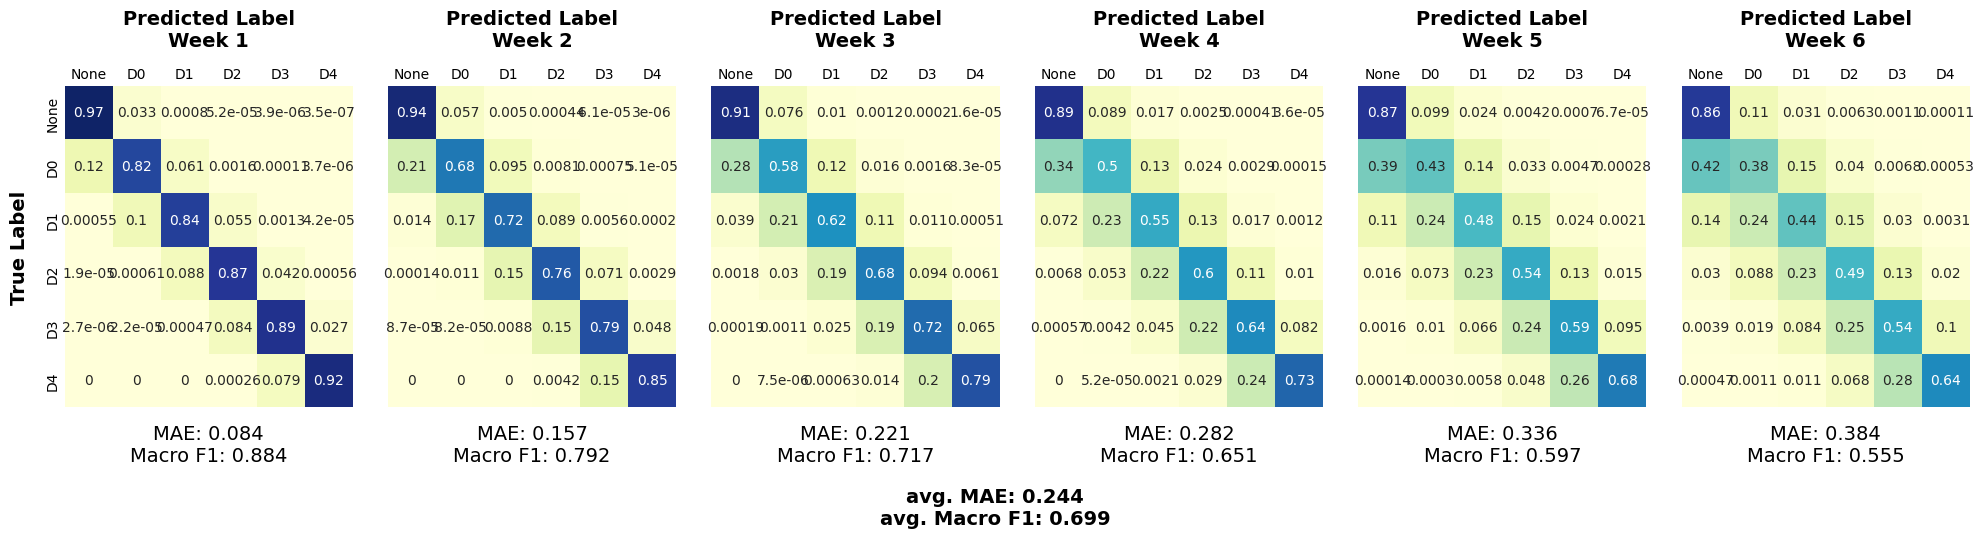

PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES


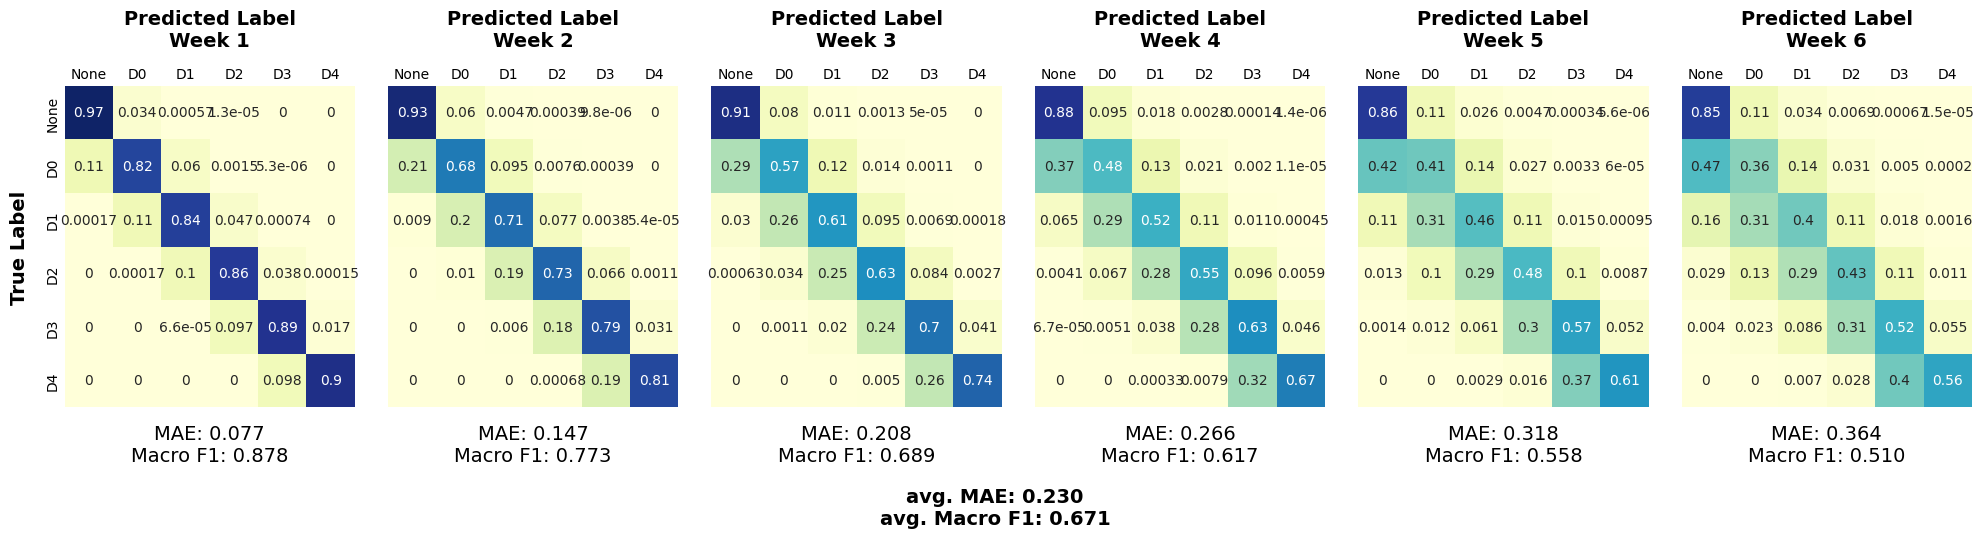

In [83]:
# 1.5 min to run
print("NAIVE MODEL, TWO OBSERVATION, PERFORMANCES")
print("------------------------------------------")
print("PREDICTIONS ON THE TRAIN TIMESERIES, FOR INFORMATION PURPOSES")
y_pred_train_dumb_2 = naive_predictor_two_observations(X_train_dumb)
process_outputs.summarize(y_target_train_dumb, y_pred_train_dumb_2)

print("PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES")
y_pred_valid_dumb_2 = naive_predictor_two_observations(X_valid_dumb)
process_outputs.summarize(y_target_valid_dumb, y_pred_valid_dumb_2)

# 3. Models

## a. Ridge Regressor

### i) No normalization

Time elapsed for fitting: 0 minutes, 50 seconds
RIDGE NO NORMALIZATION, PERFORMANCES
------------------------------------------
PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES


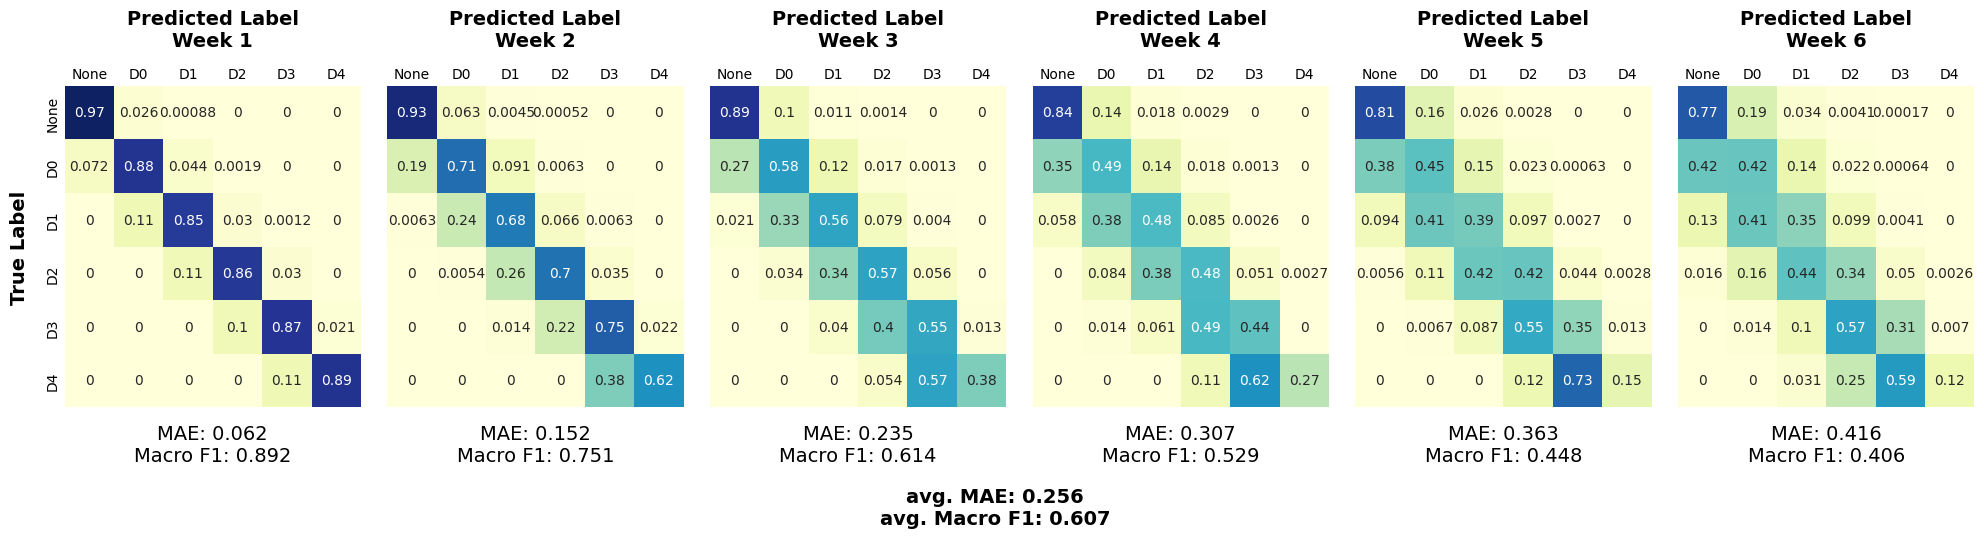

In [84]:
start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid = ridgeRegressor.predict(X_valid)
    
print("RIDGE NO NORMALIZATION, PERFORMANCES")
print("------------------------------------------")
print("PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES")
process_outputs.summarize(y_target_valid, y_pred_valid)

### ii) RobustScaler()

Time elapsed for fitting: 0 minutes, 56 seconds
RIDGE ROBUST SCALER, PERFORMANCES
---------------------------------
PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES


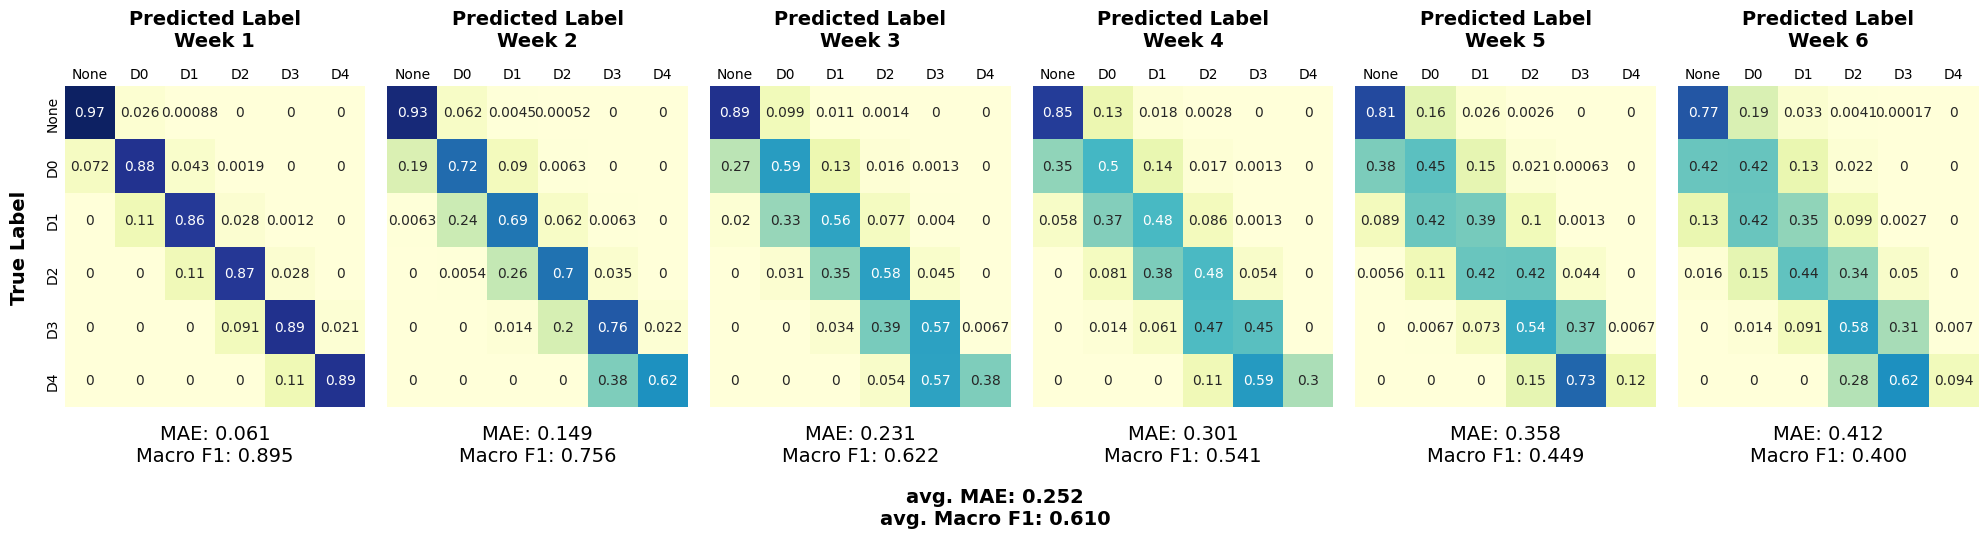

In [85]:
start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train_scaled, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid_robust = ridgeRegressor.predict(X_valid_scaled)

print("RIDGE ROBUST SCALER, PERFORMANCES")
print("---------------------------------")
print("PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES")
process_outputs.summarize(y_target_valid, y_pred_valid_robust)

### iii) Min-max normalization

Time elapsed for fitting: 0 minutes, 50 seconds
RIDGE MIN-MAX-NORM, PERFORMANCES
--------------------------------
PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES


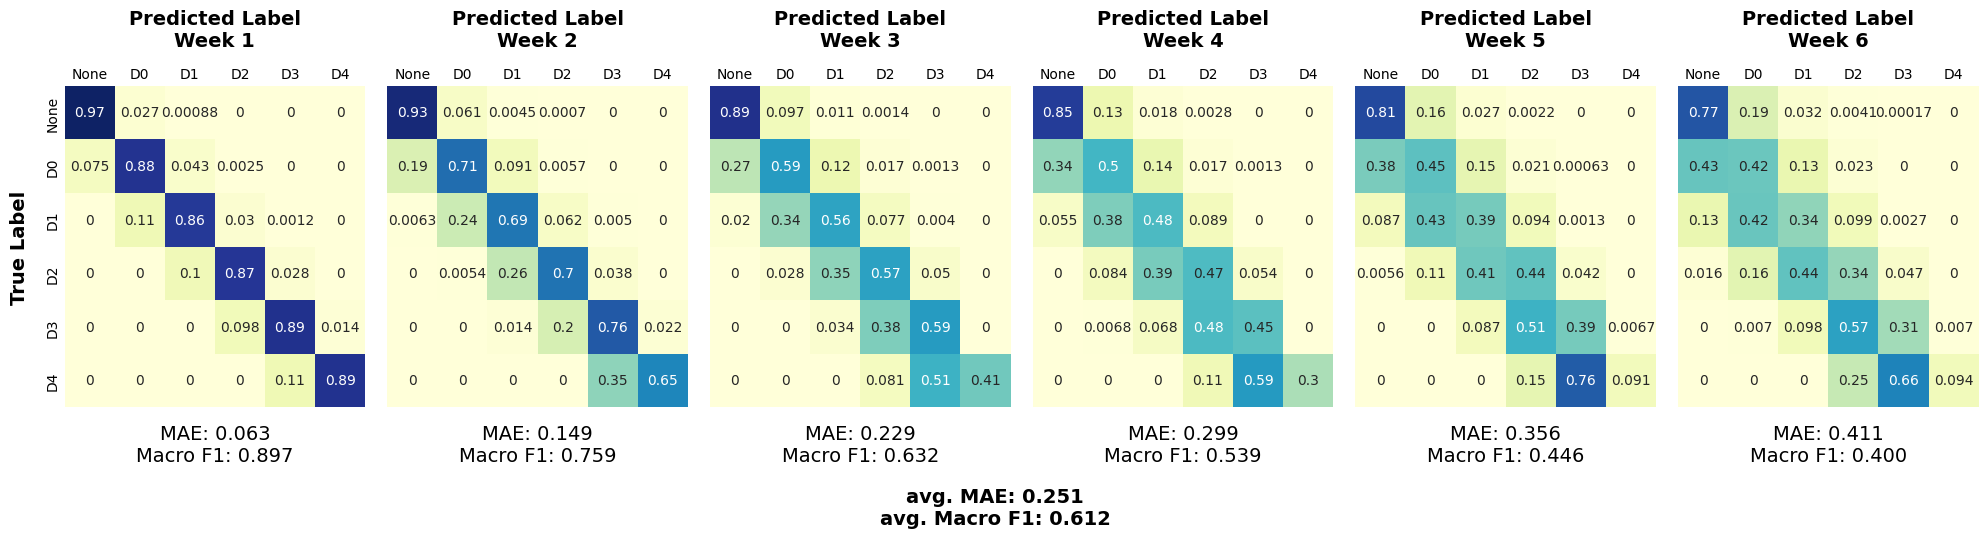

In [86]:
start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train_norm, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid_norm = ridgeRegressor.predict(X_valid_norm)

print("RIDGE MIN-MAX-NORM, PERFORMANCES")
print("--------------------------------")
print("PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES")
process_outputs.summarize(y_target_valid, y_pred_valid_norm)

## c. Gradient Boosting Regressor

      Iter       Train Loss   Remaining Time 
         1           1.5454            6.61m
         2           1.2647            6.35m
         3           1.0371            6.18m
         4           0.8526            5.93m
         5           0.7021            5.71m
         6           0.5800            5.47m
         7           0.4811            5.25m
         8           0.4007            5.02m
         9           0.3355            4.78m
        10           0.2824            4.56m
        20           0.0805            2.28m
        30           0.0513            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.5661            6.50m
         2           1.2974            6.34m
         3           1.0789            6.16m
         4           0.9020            5.91m
         5           0.7579            5.67m
         6           0.6407            5.43m
         7           0.5458            5.21m
         8           0.4689            4.99m
        

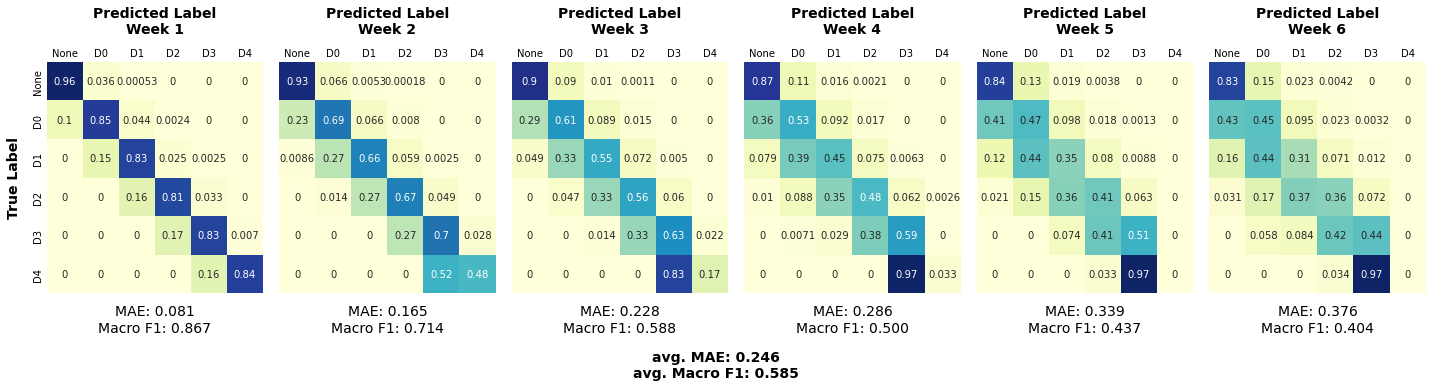

In [20]:
gbRegressor = MultiOutputRegressor(GradientBoostingRegressor(n_estimators = 30, verbose = 1))
gbRegressor.fit(X_train, np.squeeze(y_target_train))

y_pred_valid_gb = gbRegressor.predict(X_valid)

print("RIDGE MIN-MAX-NORM, PERFORMANCES")
print("--------------------------------")
print("PREDICTIONS ON THE VALIDATION TIMESERIES, FOR COMPARISON PURPOSES")
process_outputs.summarize(y_target_valid, y_pred_valid_gb)

# 4. Dimensionality Reduction - Features selection

In [88]:
# Reload deleted variables
train_timeseries = preprocessing.load_clean_data("train")
val_timeseries = preprocessing.load_clean_data("validation")
soil_data = preprocessing.load_clean_data("soil")

Loading existing clean train data
Loading existing clean validation data
Loading existing clean soil data


## a. Correlation analysis

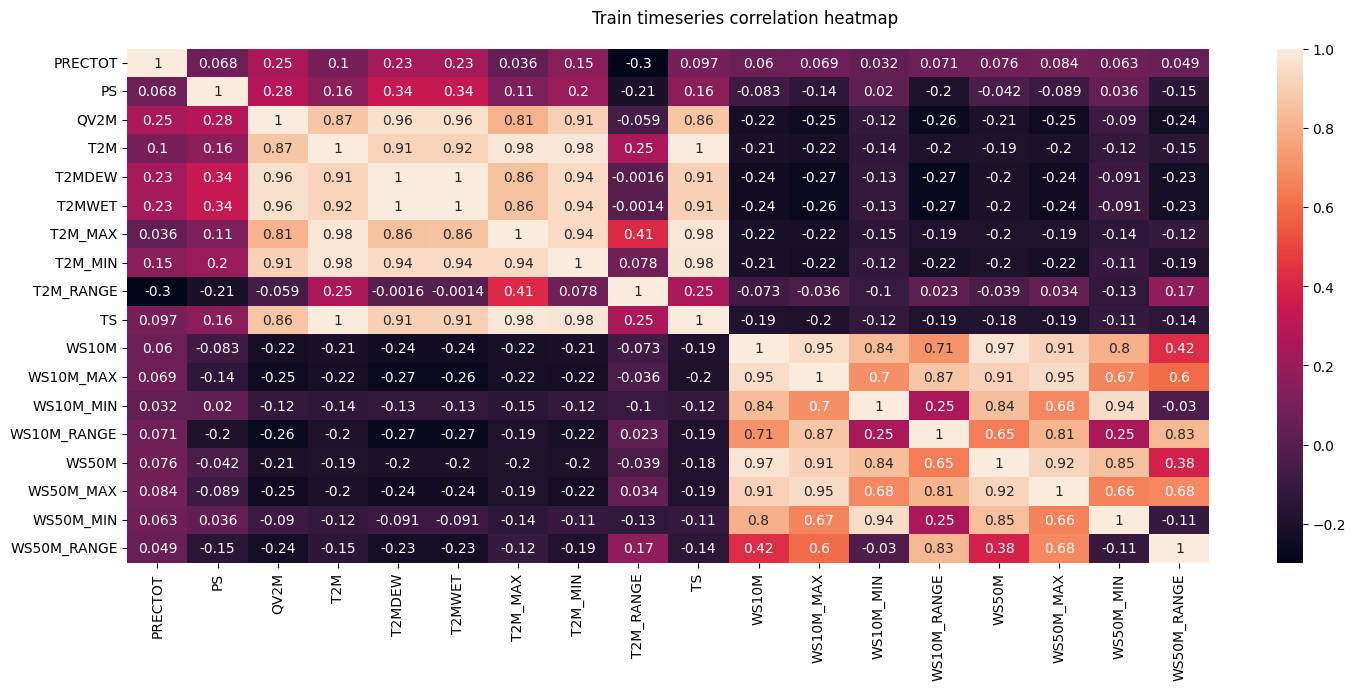

In [89]:
corr_matrix = train_timeseries.drop(columns = ['fips', 'date', 'score']).corr()
fig, ax = plt.subplots(figsize = (15, 7))
sns.heatmap(corr_matrix, annot = True, ax=ax)
plt.suptitle("Train timeseries correlation heatmap")
plt.tight_layout()

We identify two groups of correlated variables:
- Temperature variables: `QV2M`, `T2M`, `T2MDEW`, `T2MWET`, `T2M_MAX`, `T2M_MIN` and `TS`
- Wind variables: `WS10M`, `WS10M_MAX`, `WS10M_MIN`, `WS10M_RANGE`, `WS50M`, `WS50M_MAX`, `WS50M_MIN` and `WS50M_RANGE`

In [90]:
# Standardize the data to prepare for PCA
scaler = StandardScaler()
PCA_df = scaler.fit_transform(train_timeseries.drop(columns = ['fips', 'date', 'score']))

# Perform PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(PCA_df)

In [91]:
loadings = pd.DataFrame(pca.components_.T[:,:2],columns=['PC1','PC2'],index=train_timeseries.drop(columns = ['fips', 'date', 'score']).columns)
# Display the top 10 loading and their corresponding column names for PC1
print("The top 10 loadings (weights) of the first Principal Component and their corresponding column names are:")
display(loadings['PC1'][abs(loadings['PC1']).nlargest(n=15).index])
print('---')
print("The top 10 loadings (weights) of the second Principal Component and their corresponding column names are:")
display(loadings['PC2'][abs(loadings['PC2']).nlargest(n=15).index])

The top 10 loadings (weights) of the first Principal Component and their corresponding column names are:


T2MWET        -0.303462
T2MDEW        -0.303367
T2M_MIN       -0.301162
T2M           -0.298664
TS            -0.294633
QV2M          -0.293383
T2M_MAX       -0.289365
WS10M_MAX      0.250381
WS10M          0.244281
WS50M_MAX      0.243601
WS50M          0.235996
WS10M_RANGE    0.213737
WS10M_MIN      0.180016
WS50M_MIN      0.170286
WS50M_RANGE    0.154898
Name: PC1, dtype: float64

---
The top 10 loadings (weights) of the second Principal Component and their corresponding column names are:


WS50M          0.326066
WS10M          0.321404
WS50M_MAX      0.312240
WS10M_MAX      0.310453
WS50M_MIN      0.284116
WS10M_MIN      0.284020
TS             0.237251
T2M            0.232675
T2M_MIN        0.231446
WS10M_RANGE    0.223162
T2M_MAX        0.220211
T2MWET         0.220102
T2MDEW         0.219814
QV2M           0.211785
WS50M_RANGE    0.134285
Name: PC2, dtype: float64

> The 7 most important loadings of the first Principal Components are supported by the 7 `temperature` correlated features


> The 6 most important loadings of the second Principal Components are supported by the 6 `wind` correlated features

## b. Reduction of dimensionality - Part 1 - W and T point variables

We thus try to incorporate the information given in these correlated variables in less variables. We create:
- a `T_COMP` compounded variable that is the mean of all of the 7 temperature correlated variables (loadings of PC1 are more or less equal for all of these variables)
- a `W_COMP` compounded variable that is the mean of `WS10M`, `WS50M`, `WS10M_MIN`, `WS50M_MIN`, `WS10M_MAX` and `WS50M_MAX`

In [94]:
train_timeseries_low_dim_1 = preprocessing.get_lower_dimension_1("train")
val_timeseries_low_dim_1 = preprocessing.get_lower_dimension_1("validation")

Loading existing clean train data


100%|██████████| 18996390/18996390 [18:48<00:00, 16839.55it/s]


Loading existing clean validation data


100%|██████████| 2233070/2233070 [02:11<00:00, 16946.74it/s]


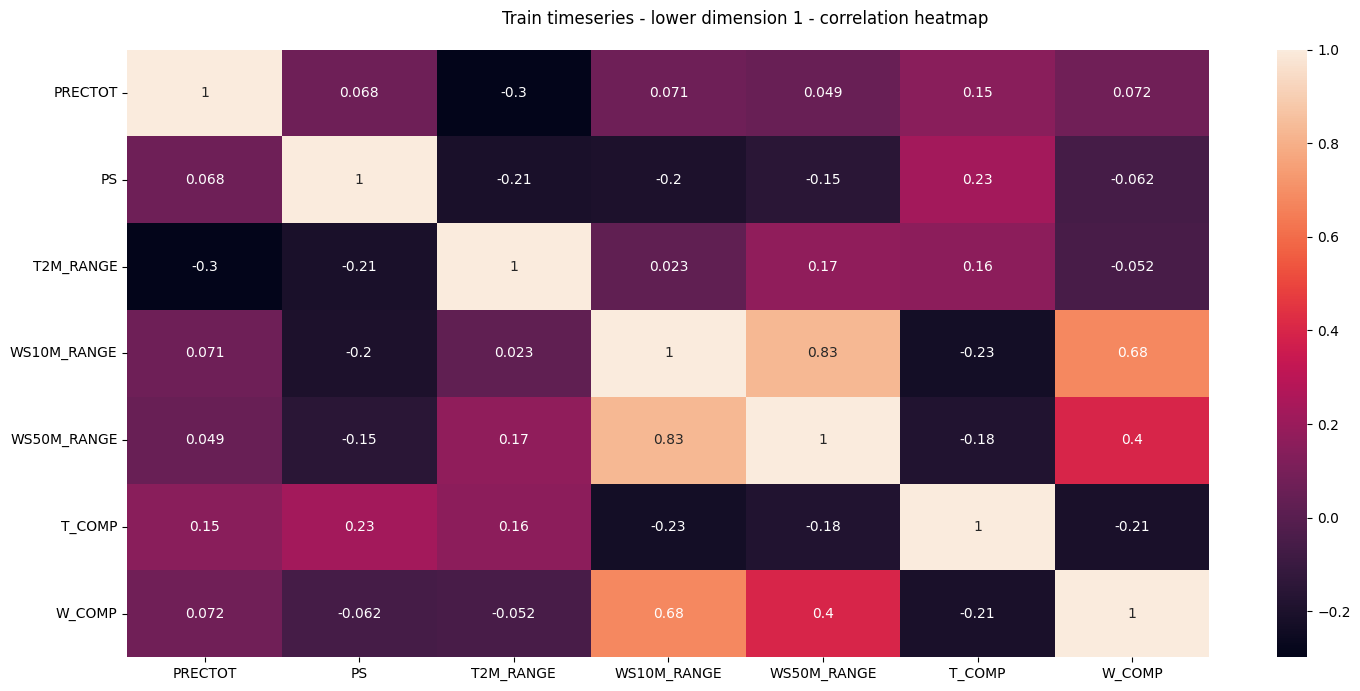

In [99]:
corr_matrix = train_timeseries_low_dim_1.drop(columns = ['fips', 'date', 'score']).corr()
fig, ax = plt.subplots(figsize = (15, 7))
sns.heatmap(corr_matrix, annot = True, ax=ax)
plt.suptitle("Train timeseries - lower dimension 1 - correlation heatmap")
plt.tight_layout()

In [98]:
X_train, y_target_train = preprocessing.transform_data_2d(train_timeseries_low_dim_1, soil_data)
X_valid, y_target_valid = preprocessing.transform_data_2d(val_timeseries_low_dim_1, soil_data)

X_train_scaled, X_valid_scaled = preprocessing.custom_scaler(X_train, X_valid)

normalization_coefficients = X_train.max(axis = 0)
X_train_norm = X_train / normalization_coefficients
X_valid_norm = X_valid / normalization_coefficients

100%|██████████| 3059/3059 [00:52<00:00, 58.42it/s]


### i) RobustScaler

Time elapsed for fitting: 0 minutes, 17 seconds


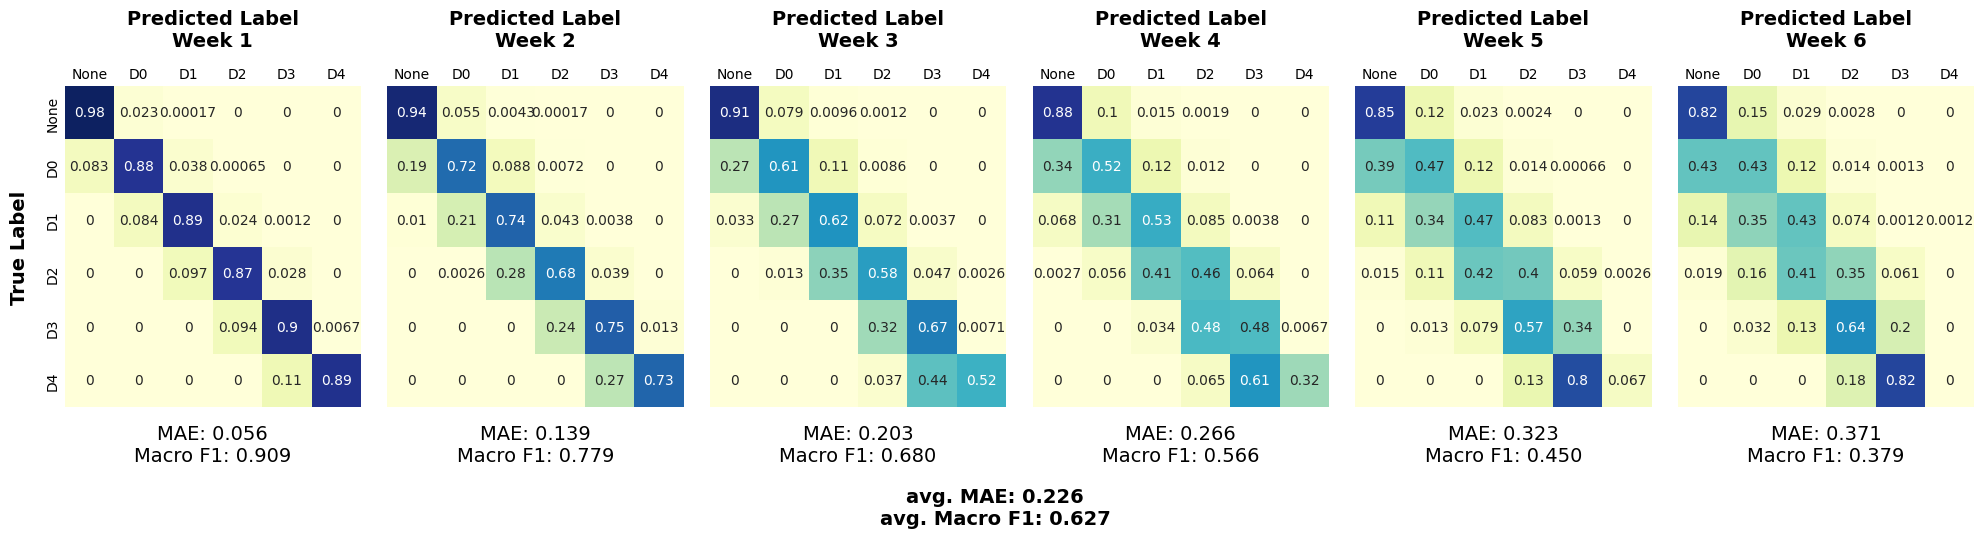

In [100]:
start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train_scaled, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid_robust = ridgeRegressor.predict(X_valid_scaled)
    
process_outputs.summarize(y_target_valid, y_pred_valid_robust)

### ii) Min-max normalization

Time elapsed for fitting: 0 minutes, 17 seconds


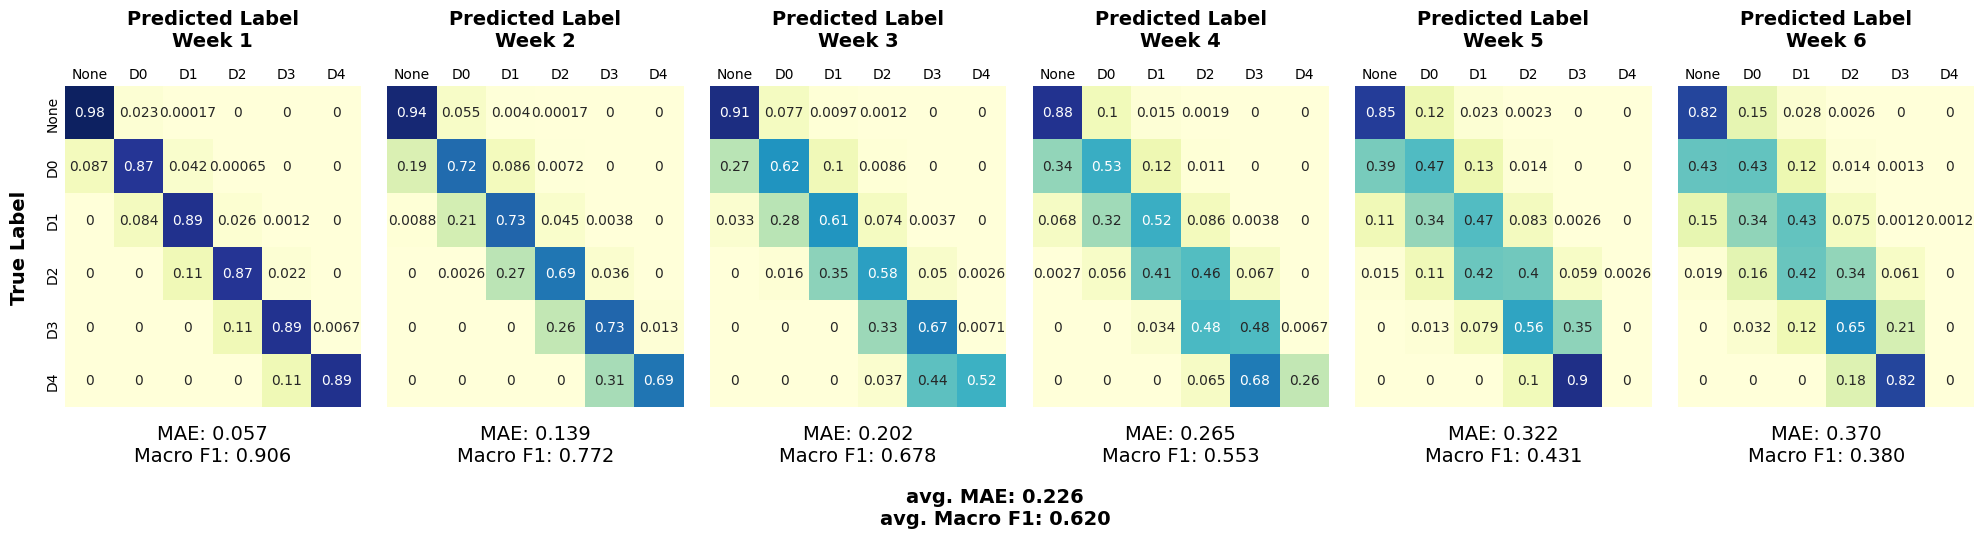

In [101]:
start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train_norm, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid_norm = ridgeRegressor.predict(X_valid_norm)
    
process_outputs.summarize(y_target_valid, y_pred_valid_norm)

## c. Reduction of dimensionality - Part 2 - W and T ranges

In [105]:
train_timeseries_low_dim_2 = preprocessing.get_lower_dimension_2("train")
val_timeseries_low_dim_2 = preprocessing.get_lower_dimension_2("validation")

train_timeseries_low_dim_3 = preprocessing.get_lower_dimension_3("train")
val_timeseries_low_dim_3 = preprocessing.get_lower_dimension_3("validation")

100%|██████████| 2233070/2233070 [02:10<00:00, 17119.51it/s]


### i) With compounded 10m and 50m wind range

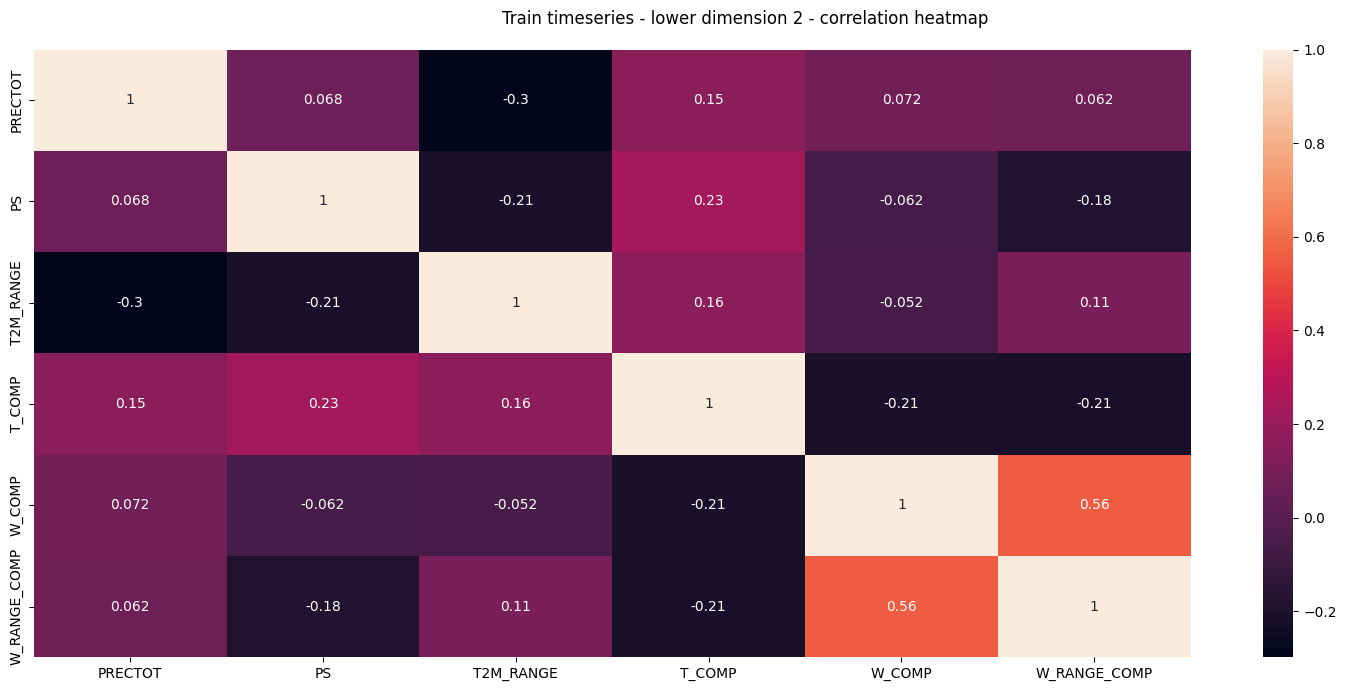

In [106]:
corr_matrix = train_timeseries_low_dim_2.drop(columns = ['fips', 'date', 'score']).corr()
fig, ax = plt.subplots(figsize = (15, 7))
sns.heatmap(corr_matrix, annot = True, ax=ax)
plt.suptitle("Train timeseries - lower dimension 2 - correlation heatmap")
plt.tight_layout()

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

Time elapsed for fitting: 0 minutes, 10 seconds


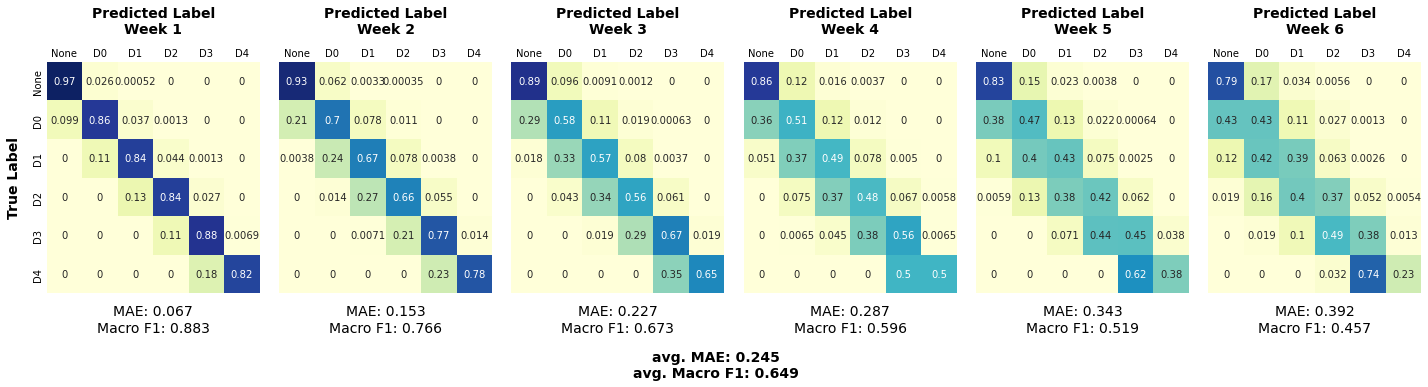

In [38]:
X_train, y_target_train = preprocessing.transform_data_2d(train_timeseries_low_dim_2, soil_data)
X_valid, y_target_valid = preprocessing.transform_data_2d(val_timeseries_low_dim_2, soil_data)

normalization_coefficients = X_train.max(axis = 0)
X_train_norm = X_train / normalization_coefficients
X_valid_norm = X_valid / normalization_coefficients

start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train_norm, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid_norm = ridgeRegressor.predict(X_valid_norm)
    
process_outputs.summarize(y_target_valid, y_pred_valid_norm)

### ii) Without any wind range information

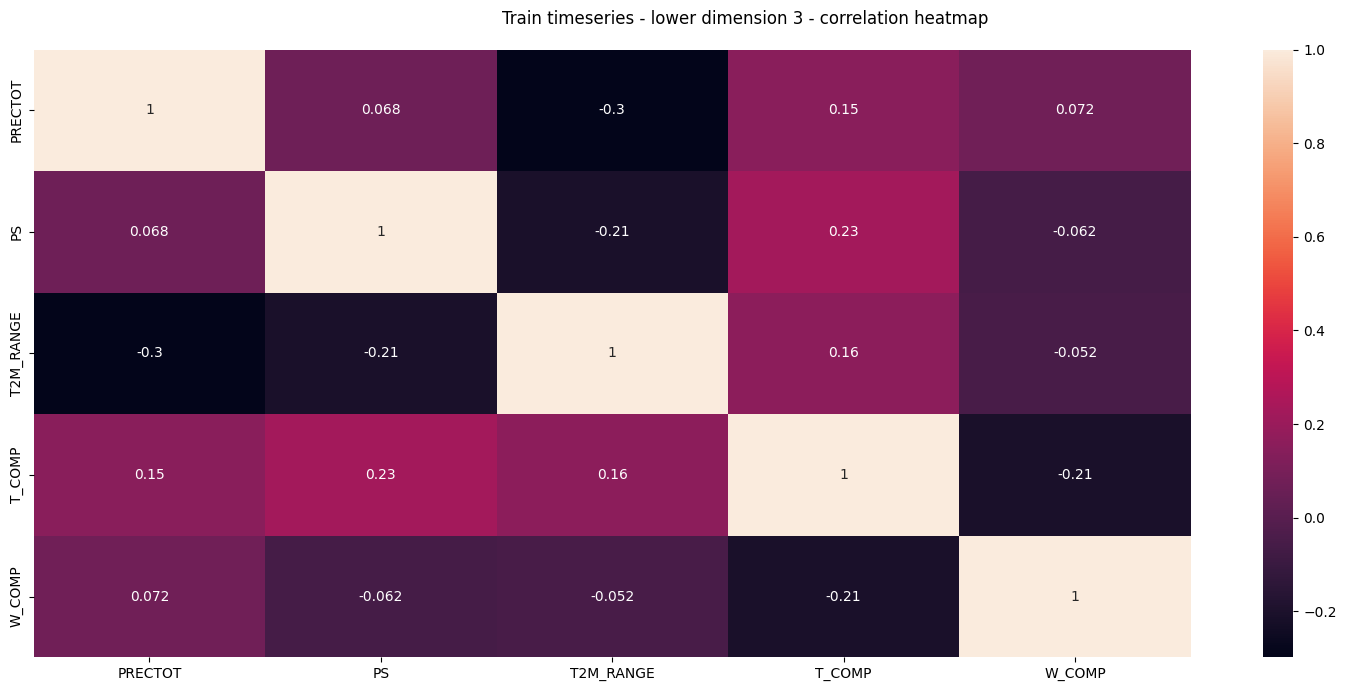

In [107]:
corr_matrix = train_timeseries_low_dim_3.drop(columns = ['fips', 'date', 'score']).corr()
fig, ax = plt.subplots(figsize = (15, 7))
sns.heatmap(corr_matrix, annot = True, ax=ax)
plt.suptitle("Train timeseries - lower dimension 3 - correlation heatmap")
plt.tight_layout()

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

Time elapsed for fitting: 0 minutes, 8 seconds


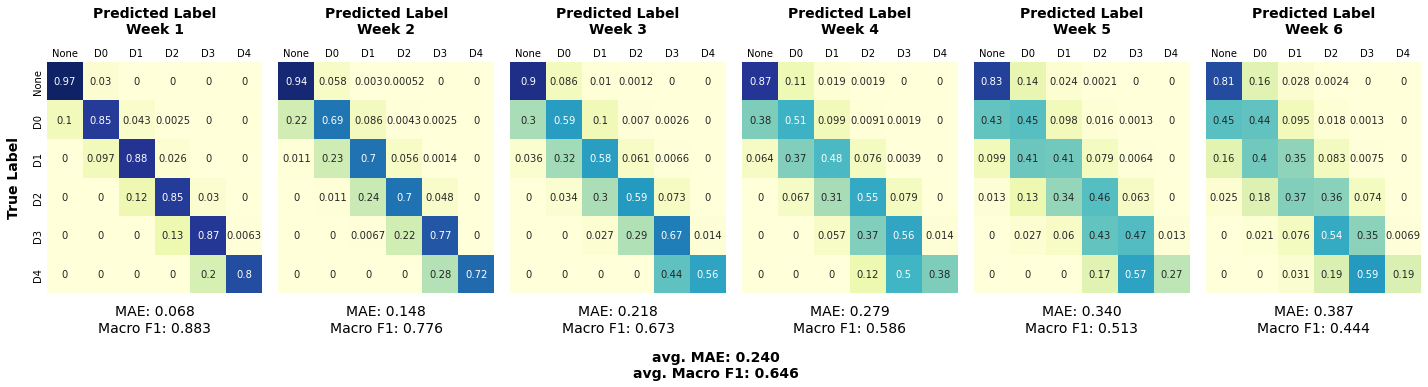

In [40]:
X_train, y_target_train = preprocessing.transform_data_2d(train_timeseries_low_dim_3, soil_data)
X_valid, y_target_valid = preprocessing.transform_data_2d(val_timeseries_low_dim_3, soil_data)

normalization_coefficients = X_train.max(axis = 0)
X_train_norm = X_train / normalization_coefficients
X_valid_norm = X_valid / normalization_coefficients

start_timer = time.time()
ridgeRegressor = MultiOutputRegressor(Ridge(alpha=0.1))
ridgeRegressor.fit(X_train_norm, np.squeeze(y_target_train))
stop_timer = time.time()
dif = stop_timer - start_timer
print(f'Time elapsed for fitting: {round(dif//60)} minutes, {round(dif%60)} seconds')

y_pred_valid_norm = ridgeRegressor.predict(X_valid_norm)
    
process_outputs.summarize(y_target_valid, y_pred_valid_norm)

## d. Reduction of dimensionality - Part 3 - Using PCA

In [45]:
if not 'train_timeseries' in locals().keys(): # Check if the concerned data is already defined
    print('Loading train_timeseries again')
    train_timeseries = pd.read_csv('../data/cleaned_train_timeseries.csv')
if not 'val_timeseries' in locals().keys(): # Check if the concerned data is already defined
    print('Loading val_timeseries again')
    val_timeseries = pd.read_csv('../data/cleaned_validation_timeseries.csv')
if not 'test_timeseries' in locals().keys(): # Check if the concerned data is already defined
    print('Loading test_timeseries again')
    test_timeseries = pd.read_csv('../data/cleaned_test_timeseries.csv')

X_train, y_target_train = preprocessing.transform_data_2d(train_timeseries, soil_data)
X_valid, y_target_valid = preprocessing.transform_data_2d(val_timeseries, soil_data)

#We delete here the loaded data to make some space on the RAM
del train_timeseries
del val_timeseries
del soil_data

normalization_coefficients = X_train.max(axis = 0)
X_train_norm = X_train / normalization_coefficients
X_valid_norm = X_valid / normalization_coefficients

Loading test_timeseries again


  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3058 [00:00<?, ?it/s]

In [46]:
# Standardize the data to prepare for PCA
scaler = StandardScaler()
scaler.fit(X_train)
prepared_X_train_norm = scaler.transform(X_train_norm)
prepared_X_valid_norm = scaler.transform(X_valid_norm)

# Perform PCA to decide how many components we want to keep
pca = PCA()
pca.fit(prepared_X_train_norm)

PCA()

Text(0.5, 1.0, 'Cumulative Variance Explained - First 50 PCs')

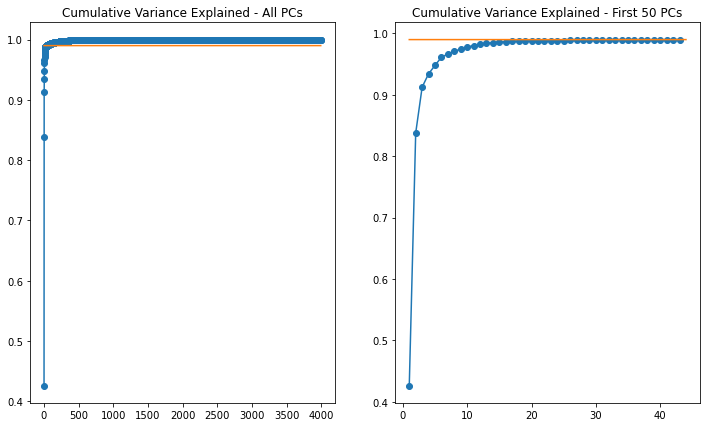

In [48]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 7))
axes[0].plot(np.arange(1,X_train_norm.shape[1]+1), cum_variance, marker = 'o')
axes[0].plot(np.arange(1,X_train_norm.shape[1]+1.01,0.01), [0.99 for i in range(len(np.arange(1,X_train_norm.shape[1]+1.01,0.01)))])
axes[0].set_title("Cumulative Variance Explained - All PCs")

axes[1].plot(np.arange(1,43+1), cum_variance[:43], marker = 'o')
axes[1].plot(np.arange(1,43+1.01,0.01), [0.99 for i in range(len(np.arange(1,43+1.01,0.01)))])
axes[1].set_title("Cumulative Variance Explained - First 50 PCs")

In [49]:
thresholds = [0.9, 0.95, 0.975, 0.99]
corresponding_PC = []
for t in thresholds:
    corresponding_PC.append(list(cum_variance > t).index(True))
print(list(zip(thresholds, corresponding_PC)))

[(0.9, 2), (0.95, 5), (0.975, 9), (0.99, 42)]


In [50]:
# Perform PCA, keep all components, and then cv on them to decide the number of components you want to keep
X_train_pca = pca.transform(prepared_X_train_norm)
X_valid_pca = pca.transform(prepared_X_valid_norm)

normalization_coefficients_pca = X_train_pca.max(axis = 0)
X_train_pca = X_train_pca / normalization_coefficients_pca
X_valid_pca = X_valid_pca / normalization_coefficients_pca

In [51]:
# How many components to keep?
def pca_components_cv(X_train_pca, y_target_train, results_dict, number_of_coefficients_list):
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle = True)
    best_f1 = 0
    best_mae = 10000 # upper bound of the mae
    best_f1_parameters = ''
    best_mae_parameters = ''
    for n in tqdm(number_of_coefficients_list):
        current_f1 = 0
        current_mae = 0
        for train_index, test_index in kf.split(X_train_pca):
            xtr, xte = X_train_pca[train_index, :n], X_train_pca[test_index, :n]
            ytr, yte = y_target_train[train_index], y_target_train[test_index]
            normalization_coefficients = xtr.max(axis = 0)
            xtr_norm = xtr / normalization_coefficients
            xte_norm = xte / normalization_coefficients
            lassoRegressor = MultiOutputRegressor(Ridge(alpha=0.1, normalize = True))
            lassoRegressor.fit(xtr_norm, np.squeeze(ytr))
            yte_pred = lassoRegressor.predict(xte_norm)
            current_f1 += process_outputs.multiple_weeks_score(yte, yte_pred)[0]
            current_mae += process_outputs.multiple_weeks_score(yte, yte_pred)[1]
        current_f1 = current_f1 / n_splits
        current_mae = current_mae / n_splits
        if current_f1 > best_f1:
            best_f1_parameters = f"{n} coefficients"
            best_f1 = current_f1
        if current_mae < best_mae:
            best_mae = current_mae
            best_mae_parameters = f"{n} coefficients"
        results_dict['parameters'] += [n]
        results_dict['f1score'] += [current_f1]
        results_dict['mae'] += [current_mae]
    return pd.DataFrame({'parameter' : [best_f1_parameters, best_mae_parameters], 'score' : [f'best f1 : {best_f1}', f'best mae : {best_mae}']})

In [52]:
results_dict = {'parameters' : [], 'f1score' : [], 'mae' : []}
number_of_coefficients_list = range(750, 3001, 250)
best_results = pca_components_cv(X_train_pca, y_target_train, results_dict, number_of_coefficients_list)

  0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
number_of_pc_results = pd.DataFrame(results_dict)
display(number_of_pc_results)
display(best_results)

,parameters,f1score,mae
0,750,0.536533,0.323679
1,1000,0.539100,0.326560
2,1250,0.543967,0.328367
3,1500,0.541500,0.330551
4,1750,0.538133,0.334996
5,2000,0.545533,0.336601
6,2250,0.545033,0.336492
7,2500,0.545633,0.339155
8,2750,0.532500,0.348979
9,3000,0.535900,0.352944


,parameter,score
0,2500 coefficients,best f1 : 0.5456333333333334
1,750 coefficients,best mae : 0.32367880972647717


# Cross validation on regularization and time window

## a) On regularization

In [54]:
if not 'train_timeseries_low_dim_2' in locals().keys(): # Check if the concerned data is already defined
    train_timeseries_low_dim_2 = pd.read_csv('../data/train_timeseries_low_dim_2.csv')
if not 'soil_data' in locals().keys(): # Check if the concerned data is already defined
    soil_data = pd.read_csv('../data/cleaned_soil_data.csv')

In [55]:
def cv_score(time_window, alpha_list, results_dict):
    X, y = preprocessing.transform_data_2d(train_timeseries_low_dim_2, soil_data, time_window = time_window, training_set = True)
    n_splits = 5
    kf = KFold(n_splits=n_splits)
    best_f1 = 0
    best_mae = 10000 # upper bound of the mae
    best_f1_parameters = ''
    best_mae_parameters = ''
    for alpha in tqdm(alpha_list):
        current_f1 = 0
        current_mae = 0
        for train_index, test_index in kf.split(X):
            xtr, xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            normalization_coefficients = xtr.max(axis = 0)
            xtr_norm = xtr / normalization_coefficients
            xte_norm = xte / normalization_coefficients
            lassoRegressor = MultiOutputRegressor(Ridge(alpha=0.1, normalize = True))
            lassoRegressor.fit(xtr_norm, np.squeeze(ytr))
            yte_pred = lassoRegressor.predict(xte_norm)
            current_f1 += process_outputs.multiple_weeks_score(yte, yte_pred)[0]
            current_mae += process_outputs.multiple_weeks_score(yte, yte_pred)[1]
        current_f1 = current_f1 / n_splits
        current_mae = current_mae / n_splits
        if current_f1 > best_f1:
            best_f1_parameters = f"best f1 with {time_window} days is with alpha = {alpha}"
            best_f1 = current_f1
        if current_mae < best_mae:
            best_mae = current_mae
            best_mae_parameters = f"best mae with {time_window} days is with alpha = {alpha}"
    del X
    del y
    if best_mae_parameters.split()[-1] == best_f1_parameters.split()[-1]:
        best_both_parameters = f"best f1 and mae with {time_window} days is with alpha = {alpha}"
        results_dict['parameters'] += [best_both_parameters]
        results_dict['f1score'] += [best_f1]
        results_dict['mae'] += [best_mae]
    else:
        results_dict['parameters'] += [best_f1_parameters]
        results_dict['f1score'] += [best_f1]
        results_dict['mae'] += ['NA']
        results_dict['parameters'] += [best_mae_parameters]
        results_dict['f1score'] += ['NA']
        results_dict['mae'] += [best_mae]

In [58]:
time_window = 180
alpha_list = [0.001, 0.01, 0.1, 1, 10]
results_dict = {'parameters' : [], 'f1score' : [], 'mae' : []}
cv_score(time_window, alpha_list, results_dict = results_dict)

results = pd.DataFrame(results_dict)
display(results)

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,parameters,f1score,mae
0,best f1 and mae with 180 days is with alpha = 10,0.611833,0.312167


## b) On time window

In [ ]:
def time_alpha_cv(time_window_list, alpha_list):
    results_dict = {'parameters' : [], 'f1score' : [], 'mae' : []}
    for time_window in tqdm(time_window_list):
        cv_score(time_window, alpha_list, results_dict)
    return results_dict

In [ ]:
time_window_list = [10, 50, 100, 180, 360]
alpha_list = [0.001, 0.01, 0.1]

results_dict = time_alpha_cv(time_window_list, alpha_list)

results = pd.DataFrame(results_dict)
display(results)

In [16]:
time_window_list = list(range(1, 10))
alpha_list = [0.1, 1, 10]

results_dict = time_alpha_cv(time_window_list, alpha_list)

results = pd.DataFrame(results_dict)
display(results)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,parameters,f1score,mae
0,best f1 and mae with 1 days is with alpha = 10,0.544800,0.306953
1,best f1 and mae with 2 days is with alpha = 10,0.602400,0.294658
2,best f1 and mae with 3 days is with alpha = 10,0.615733,0.293510
3,best f1 and mae with 4 days is with alpha = 10,0.620433,0.294219
4,best f1 and mae with 5 days is with alpha = 10,0.621600,0.295420
5,best f1 and mae with 6 days is with alpha = 10,0.622133,0.296253
6,best f1 and mae with 7 days is with alpha = 10,0.623500,0.295715
7,best f1 and mae with 8 days is with alpha = 10,0.621967,0.297690
8,best f1 and mae with 9 days is with alpha = 10,0.621667,0.298028


In [17]:
time_window_cross_validation_2 = {'time_window_list' : time_window_list, 'alpha_list' : alpha_list, 'results' : results}
f = open("time_window_cross_validation_2.pkl","wb")
pickle.dump(time_window_cross_validation_2,f)
f.close()

# 8. Simple NN

In [7]:
if 'train_timeseries_low_dim_2' not in locals().keys():
    train_timeseries_low_dim_2 = pd.read_csv('../data/train_timeseries_low_dim_2.csv')
if 'val_timeseries_low_dim_2' not in locals().keys():
    val_timeseries_low_dim_2 = pd.read_csv('../data/validation_timeseries_low_dim_2.csv')
if 'soil_data' not in locals().keys():
    soil_data = pd.read_csv('../data/cleaned_soil_data.csv')

In [8]:
X_train_7, y_target_train_7 = preprocessing.transform_data_2d(train_timeseries_low_dim_2, soil_data, time_window = 7)
X_valid_7, y_target_valid_7 = preprocessing.transform_data_2d(val_timeseries_low_dim_2, soil_data, time_window = 7)

normalization_coefficients = X_train_7.max(axis = 0)
X_train_norm_7 = X_train_7 / normalization_coefficients
X_valid_norm_7 = X_valid_7 / normalization_coefficients

  0%|          | 0/38 [00:00<?, ?it/s]

In [45]:
X_train_7_torch = torch.from_numpy(X_train_norm_7)
y_target_train_7 = torch.tensor(y_target_train_7)
X_valid_7_torch = torch.from_numpy(X_valid_norm_7)
y_target_valid_7 = torch.tensor(y_target_valid_7)

train_data_7 = torch.utils.data.TensorDataset(X_train_7_torch,y_target_train_7)
valid_data_7 = torch.utils.data.TensorDataset(X_valid_7_torch,y_target_valid_7)

EPOCHS = 20
BATCH_SIZE = 128

train_dataloader_7 = torch.utils.data.DataLoader(dataset = train_data_7, batch_size = BATCH_SIZE, drop_last=True, shuffle =True)
valid_dataloader_7 = torch.utils.data.DataLoader(dataset = valid_data_7, batch_size = BATCH_SIZE, drop_last=True, shuffle =True)

if torch.cuda.is_available():
    device = torch.device('cuda')  
    print("cuda is available")
else:
    device = torch.device("cpu")

cuda is available


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [47]:
class Net(nn.Module):
    def __init__(self, input_size):
        self._input_size = input_size
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(self._input_size, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

In [58]:
def one_batch_train(model, x, y, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x.float())
    loss =criterion(output,y.float())
    loss.backward()
    optimizer.step()

    return loss, output

In [67]:
def train(model, train_dataloader, X_valid_torch, 
          y_target_valid, optimizer, criterion, EPOCHS, 
         save_filename = None):
    train_f1, train_mae, valid_f1, valid_mae = [], [], [], []
    for epoch in tqdm(range(EPOCHS)):
        avg_f1_score = 0
        avg_mae = 0
        for bidx, batch in enumerate(train_dataloader):
            x_train, y_train = batch[0], batch[1]
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            loss, predictions = one_batch_train(model,x_train,y_train, optimizer, criterion)
            y_pred = torch.zeros(BATCH_SIZE, 6)
            for idx, y_hat in enumerate(predictions):
                y_pred_i  = torch.round(y_hat)
                y_pred[idx] = y_pred_i
            f1, mae = process_outputs.multiple_weeks_score(y_train.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
            avg_f1_score += f1
            avg_mae += mae
        avg_f1_score = (avg_f1_score/len(train_dataloader_7))
        avg_mae = (avg_mae/len(train_dataloader_7))
        train_f1.append(avg_f1_score)
        train_mae.append(avg_mae)
        print('Epoch {} train avg_f1_score : {}'.format(epoch+1, avg_f1_score))
        print('Epoch {} train avg_mae : {}'.format((epoch+1),avg_mae))
        
        # predictions on validation set on 2000 points
        perm = torch.randperm(2000)
        y_valid_pred = model(X_valid_7_torch[perm].to(device).float())
        valid_f1_current, valid_mae_current = process_outputs.multiple_weeks_score(y_target_valid_7[perm].detach().cpu().numpy(), 
                                                                   y_valid_pred.detach().cpu().numpy())
        valid_f1.append(valid_f1_current)
        valid_mae.append(valid_mae_current)
        print('Epoch {} valid avg_f1_score : {}'.format(epoch+1, valid_f1_current))
        print('Epoch {} valid avg_mae : {}'.format((epoch+1),valid_mae_current))
    if save_filename:
        torch.save(model.state_dict(), save_filename)
    return train_f1, train_mae, valid_f1, valid_mae

In [68]:
net = Net(X_train_norm_7.shape[1]).to(device)
net.apply(init_weights)
criterion = nn.MSELoss()
optm = Adam(net.parameters(), lr = 0.001)

In [ ]:
train_f1, train_mae, valid_f1, valid_mae = train(net, train_dataloader_7, X_valid_7_torch, y_target_valid_7, 
     optm, criterion, EPOCHS, 'first_net.pkl')

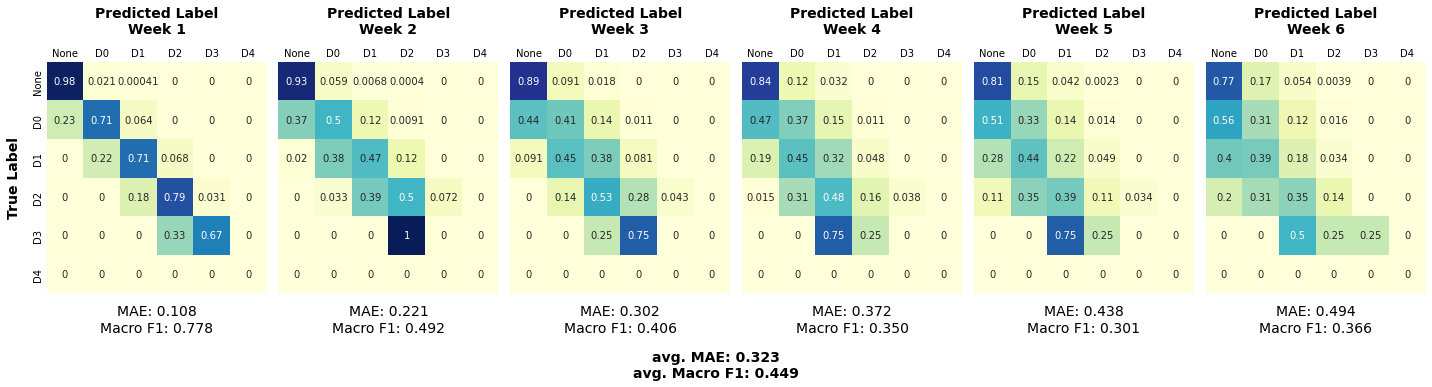

In [70]:
y_valid_pred = net(X_valid_7_torch.to(device).float())
#valid_f1_current, valid_mae_current = multiple_weeks_score(y_target_valid_7.detach().cpu().numpy(), y_valid_pred.detach().cpu().numpy())
preprocessing.summarize(y_target_valid_7.detach().cpu().numpy(), 
                     y_valid_pred.detach().cpu().numpy())

In [ ]:
torch.save(net.state_dict(), 'first_net.pkl')
net = Net(X_train_norm_7.shape[1])
net.load_state_dict(torch.load('first_net.pkl'))
net.eval()